In [1]:
from init import *

### 行业map构建

In [2]:
start_date = '2018-01-01'
end_date = '2023-10-01'

indusrty_codes = []
for i in range(1,31):
    indusrty_codes.append(f"CI0050{str(i).rjust(2,'0')}.INDX")

indusrty_codes_convert = {'CI005001.INDX':'石油石化',
                            'CI005002.INDX':'煤炭',
                            'CI005003.INDX':'有色金属',
                            'CI005004.INDX':'电力及公用事业',
                            'CI005005.INDX':'钢铁',
                            'CI005006.INDX':'基础化工',
                            'CI005007.INDX':'建筑',
                            'CI005008.INDX':'建材',
                            'CI005009.INDX':'轻工制造',
                            'CI005010.INDX':'机械',
                            'CI005011.INDX':'电力设备及新能源',
                            'CI005012.INDX':'国防军工',
                            'CI005013.INDX':'汽车',
                            'CI005014.INDX':'商贸零售',
                            'CI005015.INDX':'消费者服务',
                            'CI005016.INDX':'家电',
                            'CI005017.INDX':'纺织服装',
                            'CI005018.INDX':'医药',
                            'CI005019.INDX':'食品饮料',
                            'CI005020.INDX':'农林牧渔',
                            'CI005021.INDX':'银行',
                            'CI005022.INDX':'非银行金融',
                            'CI005023.INDX':'房地产',
                            'CI005024.INDX':'交通运输',
                            'CI005025.INDX':'电子',
                            'CI005026.INDX':'通信',
                            'CI005027.INDX':'计算机',
                            'CI005028.INDX':'传媒',
                            'CI005029.INDX':'综合',
                            'CI005030.INDX':'综合金融'}

indusrty_names_convert = {}
for k,v in indusrty_codes_convert.items():
    indusrty_names_convert[v] = k
    
insts = all_instruments('CS')
# 获取股票池&研究周期
stock_list = sorted(insts[((insts['de_listed_date'] == '0000-00-00') | (insts['de_listed_date'] > start_date)) & (insts['listed_date'] <= end_date)].order_book_id.tolist())
date_list = pd.to_datetime(get_trading_dates(start_date,end_date))
# 构建行业分组
industry_map = get_industry_exposure(stock_list,date_list)

gen industry martix... 


### 时序阈值构建

In [3]:
def calc_p(df,n):
    def calculate_percentile(data, current_data):
        sorted_data = sorted(data)
        position = sorted_data.index(current_data) + 1

        return position / len(sorted_data)
    df = df.rolling(n).apply(lambda x: calculate_percentile(x,x.iloc[-1])).dropna(how = 'all')

    return df

def calc_z(df,n):
    df = ((df - df.rolling(n).mean())/(df.rolling(n).std())).dropna(how = 'all')

    return df

### 行情基础数据获取

In [4]:
ind_close = pd.read_pickle('ind_close.pkl')
ind_ret = pd.read_pickle('ind_ret.pkl')
ind_total_turnover = pd.read_pickle('ind_total_turnover.pkl')
ind_volume = pd.read_pickle('ind_volume.pkl')
ind_mc = pd.read_pickle('ind_mc.pkl')
ind_turn_ratio = pd.read_pickle('ind_turn_ratio.pkl')

### 拥挤度算子构建

In [5]:
def get_mtm(df,n):
    return df.pct_change(n)

def get_sharpe(df,n):
    df_pct = df.pct_change()
    return df_pct.rolling(n).mean()/df_pct.rolling(n).std()

def get_ir(df,n):
    benchmark_pct = get_price('000985.XSHG',
                          df.index[0],
                          df.index[-1],
                          fields='close').close.droplevel(0).pct_change()
    
    excess_df = df.sub(benchmark_pct,axis = 0)
    return excess_df.rolling(n).mean()/excess_df.rolling(n).std()

def get_distance(df,n):
    df_pct_abs = df.pct_change().abs()
    return df.pct_change(n)/df_pct_abs.rolling(n).sum()

def get_VaR(df,n):
    df_pct = df.pct_change() 
    #方差协方差法
    def VaR_VCM(ret,T = 10,X = 0.99):
        mu = ret.mean()
        sig = ret.std()
        z = abs(st.norm.ppf(q=1-X))    
        return np.sqrt(T)*(z*sig-mu)
    
    return df_pct.rolling(n).apply(lambda x: VaR_VCM(x))

def get_bias(df,n):
    ma = df.rolling(n).mean()
    bais = df.sub(ma,axis = 0).div(ma,axis = 0) 
    return bais 

def get_corr(x,y,t):
    date_list = x.index.tolist()
    x_to_y_corr = pd.DataFrame(index = date_list,columns = sorted(set(industry_map)))
    for i in range(t,len(y)):
        y_temp = y.iloc[i-t:i]
        total_turnover_industry_temp = x.iloc[i-t:i]
        x_to_y_corr.loc[y_temp.iloc[-1].name] = y_temp.corrwith(total_turnover_industry_temp)
    return x_to_y_corr

def get_coskew(df,n):
    benchmark = get_price('000985.XSHG',
                          df.index[0],
                          df.index[-1],
                          fields='close').close.droplevel(0).pct_change()
    def get_resid(y):
        y = y.dropna()
        benchmark_temp = benchmark.loc[y.index[0]:y.index[-1]]
        resid_asset = sm.OLS(y,benchmark_temp,hasconst=False, missing='drop').fit().resid
        resid_market = benchmark_temp - benchmark_temp.mean()
        return ((resid_asset * resid_market) ** 2).mean() / np.sqrt((resid_asset ** 2).mean() * (resid_market ** 2).mean())
    
    df = df.rolling(n).apply(lambda x: get_resid(x))

    return df

### 拥挤度指标衍生

In [40]:
crod_dict = {}
for t in tqdm([20,40,60]):
    """动量指标"""
    # 普通动量拥挤度
    crod_dict[f'ind_mtm_{t}'] = get_mtm(ind_close,t)
    # 夏普动量拥挤度
    crod_dict[f'ind_sharpe_{t}'] = get_sharpe(ind_close,t)
    # 信息比率拥挤度
    crod_dict[f'ind_ir_{t}'] = get_ir(ind_close,t)
    # 路径调整动量拥挤度
    crod_dict[f'ind_distance_{t}'] = get_distance(ind_close,t)
    # 尾部动量拥挤度
    crod_dict[f'ind_VaR_{t}'] = get_VaR(ind_close,t)
    """流动性指标"""
    # 成交量拥挤度
    crod_dict[f'ind_volume_{t}'] = ind_volume.rolling(t).mean()
    # 成交额拥挤度
    crod_dict[f'ind_total_turnover_{t}'] = ind_total_turnover.rolling(t).mean()
    # 换手率拥挤度
    crod_dict[f'ind_turn_ratio_{t}'] = ind_turn_ratio.rolling(t).mean()
    """量价相关性"""
    # 成交量与收盘价的相关系数
    crod_dict[f'ind_volume_close_corr_bais_{t}'] = get_corr(ind_volume,ind_mc,t)
    # 换手率与收盘价的相关系数
    crod_dict[f'ind_turn_close_corr_bais_{t}'] = get_corr(ind_turn_ratio,ind_mc,t)
    # 成交额与收盘价的相关系数
    crod_dict[f'ind_amt_close_corr_bais_{t}'] = get_corr(ind_total_turnover,ind_mc,t)
    """波动率指标"""
    # 波动率拥挤度
    crod_dict[f'ind_close_vol_{t}'] = ind_ret.rolling(t).std()
    # 下行波动率拥挤度
    crod_dict[f'ind_close_down_vol_{t}'] = ind_ret.rolling(t).apply(lambda x: x[x < 0].std())
    """分布特征指标"""
    # 峰度
    crod_dict[f'ind_close_fig_kurt_{t}'] = ind_ret.rolling(t).apply(lambda x: x.kurt())
    # 偏度
    crod_dict[f'ind_close_fig_skew_{t}'] = ind_ret.rolling(t).skew()
    # 协偏度
    crod_dict[f'ind_close_fig_skew_{t}'] = get_coskew(ind_ret,t)


for t in tqdm([20,40,60,120,250]):
    """乖离率指标"""
    # 收盘价乖离率
    crod_dict[f'ind_close_bais_{t}'] = get_bias(ind_close,t)
    # 成交量乖离率
    crod_dict[f'ind_volume_bais_{t}'] = get_bias(ind_volume,t)
    # 成交额乖离率
    crod_dict[f'ind_total_turnover_bais_{t}'] = get_bias(ind_total_turnover,t)
    # 换手率乖离率
    crod_dict[f'ind_turn_ratio_bais_{t}'] = get_bias(ind_turn_ratio,t)

pickle.dump(crod_dict,open('crod_dict.pkl','wb'))

100%|██████████| 5/5 [00:00<00:00, 212.58it/s]


In [42]:
crod_dict_p = {}
for k,v in tqdm(crod_dict.items()):
    for t in [240,360,480]:
        crod_dict_p[f'{k}_p{t}'] = calc_p(v,t)

pickle.dump(crod_dict_p,open('crod_dict_p.pkl','wb'))

100%|██████████| 65/65 [03:08<00:00,  2.90s/it]


In [70]:
crowd_dict_signal = {}
for k,v in tqdm(crod_dict_p.items()):
    if ('fig' in k) or ('corr' in k):
        for l in [0.01,0.05,0.1,0.2]:
            crowd_dict_signal[f'{k}_{int(l * 100)}'] = v[v<l]
    else:
        for h in [0.8,0.9,0.95,0.99]:
            crowd_dict_signal[f'{k}_{int(h * 100)}'] = v[v>h]

  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [00:00<00:00, 913.87it/s]


In [72]:
pickle.dump(crowd_dict_signal,open('crowd_dict_signal.pkl','wb'))

In [7]:
list(crowd_dict_signal.keys())

['ind_mtm_20_p240_80',
 'ind_mtm_20_p240_90',
 'ind_mtm_20_p240_95',
 'ind_mtm_20_p240_99',
 'ind_mtm_20_p360_80',
 'ind_mtm_20_p360_90',
 'ind_mtm_20_p360_95',
 'ind_mtm_20_p360_99',
 'ind_mtm_20_p480_80',
 'ind_mtm_20_p480_90',
 'ind_mtm_20_p480_95',
 'ind_mtm_20_p480_99',
 'ind_sharpe_20_p240_80',
 'ind_sharpe_20_p240_90',
 'ind_sharpe_20_p240_95',
 'ind_sharpe_20_p240_99',
 'ind_sharpe_20_p360_80',
 'ind_sharpe_20_p360_90',
 'ind_sharpe_20_p360_95',
 'ind_sharpe_20_p360_99',
 'ind_sharpe_20_p480_80',
 'ind_sharpe_20_p480_90',
 'ind_sharpe_20_p480_95',
 'ind_sharpe_20_p480_99',
 'ind_ir_20_p240_80',
 'ind_ir_20_p240_90',
 'ind_ir_20_p240_95',
 'ind_ir_20_p240_99',
 'ind_ir_20_p360_80',
 'ind_ir_20_p360_90',
 'ind_ir_20_p360_95',
 'ind_ir_20_p360_99',
 'ind_ir_20_p480_80',
 'ind_ir_20_p480_90',
 'ind_ir_20_p480_95',
 'ind_ir_20_p480_99',
 'ind_distance_20_p240_80',
 'ind_distance_20_p240_90',
 'ind_distance_20_p240_95',
 'ind_distance_20_p240_99',
 'ind_distance_20_p360_80',
 'ind_di

### 指标统计检验

In [8]:
crowd_dict_signal = pd.read_pickle('crowd_dict_signal.pkl')

#### P值显著性统计

In [9]:
# 显著性测试
industry_ret20 = get_price(indusrty_codes,
                           start_date,
                           end_date,
                           fields='close').close.unstack('order_book_id').pct_change(20).shift(-20).dropna(how = 'all')

pvalues_record_df = pd.DataFrame(index = indusrty_codes)
for k,v in tqdm(crowd_dict_signal.items()):

    inter_index = sorted(set(v.index) & set(industry_ret20.index))
    
    def get_pvalues(df):
        recrod = pd.DataFrame(index = indusrty_codes,columns = ['rsquared'])
        for i in indusrty_codes:
            try:
                y = industry_ret20.loc[inter_index,i]
                x = df.loc[inter_index,i].notnull()
                result = sm.OLS(y.astype(float),sm.add_constant(x.astype(float)),hasconst=False, missing='drop').fit()
                recrod.loc[i] = result.pvalues[1]
            except:
                recrod.loc[i] = np.nan
        return recrod
    
    recrod_p = get_pvalues(v)
    pvalues_record_df[f'{k}_pvalues'] = recrod_p

100%|██████████| 780/780 [01:25<00:00,  9.12it/s]


In [10]:
pvalues_record_df = pvalues_record_df.dropna(how = 'all',axis = 1)

In [15]:
(pvalues_record_df[pvalues_record_df < 0.01].count()/30).sort_values(ascending = False)

ind_volume_60_p240_90_pvalues             0.866667
ind_turn_ratio_60_p240_95_pvalues         0.866667
ind_turn_ratio_60_p240_90_pvalues         0.833333
ind_turn_ratio_20_p360_95_pvalues         0.833333
ind_distance_60_p240_80_pvalues           0.833333
                                            ...   
ind_turn_ratio_bais_60_p360_99_pvalues    0.033333
ind_turn_ratio_bais_20_p360_99_pvalues    0.000000
ind_turn_ratio_bais_20_p480_99_pvalues    0.000000
ind_turn_ratio_bais_40_p360_99_pvalues    0.000000
ind_turn_ratio_bais_40_p480_99_pvalues    0.000000
Length: 672, dtype: float64

<Axes: >

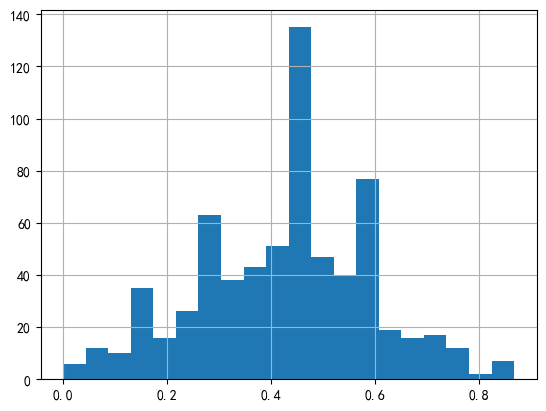

In [11]:
(pvalues_record_df[pvalues_record_df < 0.01].count()/30).sort_values().hist(bins = 20)

In [104]:
pvalues_record_pass_ratio = (pvalues_record_df[pvalues_record_df < 0.01].count()/30)
pvalues_record_pass_names = pvalues_record_pass_ratio[pvalues_record_pass_ratio > 0.5].index.tolist()

#### 胜率显著性统计

In [24]:
# 胜率测试
industry_ret20 = get_price(indusrty_codes,
                           start_date,
                           end_date,
                           fields='close').close.unstack('order_book_id').pct_change(20).shift(-20).dropna(how = 'all')

benchmark_ret20 = get_price('000985.XSHG',
                          start_date,
                           end_date,
                          fields='close').close.droplevel(0).pct_change(20).shift(-20).dropna(how = 'all')

excess_industry_ret20 = (industry_ret20.sub(benchmark_ret20,axis = 0) > 0 ).astype(int)

win_ratio = pd.DataFrame(index = indusrty_codes)
for k,v in tqdm(crowd_dict_signal.items()):
    inter_index = sorted(set(v.index) & set(industry_ret20.index))
    excess_industry_ret20_filter = excess_industry_ret20.loc[inter_index].mask(v.isnull())
    # 拥挤度，越跌越好
    # win_ratio[f'{k}_Len{len(inter_index)}'] = 1 - excess_industry_ret20_filter.sum()/excess_industry_ret20_filter.count()
    win_ratio[f'{k}'] = 1 - excess_industry_ret20_filter.sum()/excess_industry_ret20_filter.count()

100%|██████████| 780/780 [00:04<00:00, 169.40it/s]


<Axes: >

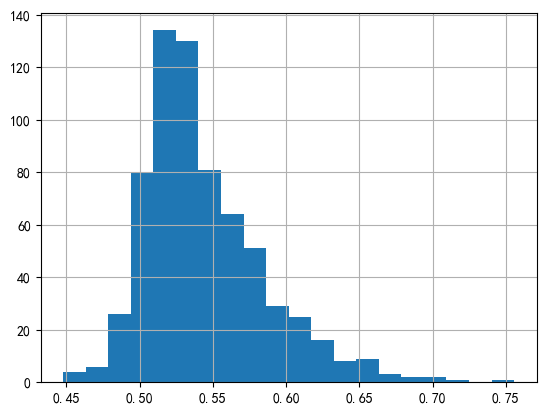

In [20]:
win_ratio = win_ratio.dropna(how = 'all',axis = 1)
win_ratio.mean().sort_values().hist(bins = 20)

In [103]:
win_ratio_mean = win_ratio.mean()
win_pass_names = win_ratio_mean[win_ratio_mean > 0.5].index.tolist()

In [105]:
pass_factor_names = sorted(set([i[:-8] for i in pvalues_record_pass_names]) & set(win_pass_names))

In [106]:
pass_siganl = {}

for k,v in crowd_dict_signal.items():
    if k in pass_factor_names:
        pass_siganl[k] = v

In [107]:
ret_performance = pd.DataFrame()
for k,v in pass_siganl.items():
    ret_performance[k] = ind_ret.mask(v.ffill(limit = 60).isnull()).mean(axis = 1)
ret_performance = ret_performance.dropna(how = 'all')

<Axes: xlabel='date'>

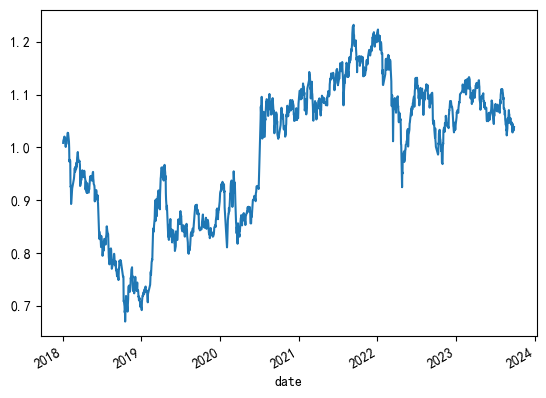

In [108]:
(ind_ret.mean(axis = 1) + 1).cumprod().plot()

#### 收益回测统计

In [109]:
benchmark_ret = ind_ret.mean(axis = 1)
def performance_calc(series,name):
    net = series.dropna().to_frame('net')
    date_list_temp = get_trading_dates(net.index[0],net.index[-1])
    net = net.reindex(date_list_temp)
    net['benchmark'] = benchmark_ret
    cumnet = (net + 1).cumprod().ffill()
    cumnet['alpha'] = cumnet['net']/cumnet['benchmark']
    # 回测指标计算
    T = cumnet['net']
    ET = cumnet['alpha']
    # 计算几何年化收益率
    year_ret_sqrt = T.iloc[-1]**(252/len(T))-1
    year_ret_sqrt = round(year_ret_sqrt*100,2)
    # 计算超额几何年化收益率
    excess_year_ret_sqrt = ET.iloc[-1]**(252/len(ET))-1
    excess_year_ret_sqrt = round(excess_year_ret_sqrt*100,2)
    # 波动率
    volitiy = T.pct_change().dropna().std()*np.sqrt(252)
    volitiy = round(volitiy*100,2)
    # 夏普比率
    Sharpe = (year_ret_sqrt - 3)/volitiy
    Sharpe = round(Sharpe,2)
    # 最大回撤 
    i = np.argmax((np.maximum.accumulate(T) - T)/np.maximum.accumulate(T))
    j = np.argmax(T[:i])
    downlow = round((1-T[i]/T[j])*100,2)

    result = pd.DataFrame([year_ret_sqrt,excess_year_ret_sqrt,volitiy,Sharpe,downlow],
                            columns = [name],
                            index = ['年化收益率','超额年化收益率','波动率','夏普比率','最大回测'])

    return result

In [110]:
backtest_performance = pd.DataFrame()
for i in tqdm(ret_performance.columns.tolist()):
    backtest_performance = pd.concat([backtest_performance,performance_calc(ret_performance[i],i)],axis = 1)

100%|██████████| 187/187 [00:00<00:00, 433.78it/s]


In [112]:
backtest_performance.T.sort_values(by = '夏普比率',ascending=False).head(30)

,年化收益率,超额年化收益率,波动率,夏普比率,最大回测
ind_close_bais_20_p240_95,18.28,9.32,20.52,0.74,19.77
ind_close_bais_40_p360_90,15.88,9.75,20.27,0.64,21.23
ind_close_bais_60_p480_80,14.57,7.35,18.51,0.63,21.14
ind_close_bais_60_p360_90,15.66,10.69,21.08,0.60,19.88
ind_close_vol_20_p360_90,16.45,11.36,22.77,0.59,22.31
ind_close_bais_20_p360_90,13.93,7.18,18.99,0.58,23.24
ind_mtm_20_p360_90,13.49,6.77,19.39,0.54,22.59
ind_close_vol_20_p240_80,14.85,7.25,22.28,0.53,24.32
ind_close_vol_60_p480_95,15.17,7.35,23.51,0.52,31.43
ind_mtm_20_p360_95,13.63,8.16,21.29,0.50,23.16


### 行业拥挤指标合成回测

In [155]:
crowd_factor_names = ['ind_close_bais_20_p240_95',
                        'ind_mtm_20_p360_90',
                        'ind_close_vol_20_p240_80',
                        'ind_sharpe_40_p360_90',
                        'ind_volume_40_p360_90']

corwd_combo = pd.DataFrame()

for i in crowd_factor_names:
    corwd_combo = corwd_combo.add(crowd_dict_signal[i].notnull().astype(int),fill_value=0)

corwd_combo = corwd_combo.dropna(how = 'all')

In [156]:
corwd_combo.stack().value_counts()

0.0    22805
1.0     7339
2.0     2868
3.0      786
4.0      284
5.0       88
Name: count, dtype: int64

In [157]:
performance_record_level = pd.DataFrame()
for i in range(1,5):
    corwd_combo_mask = corwd_combo[corwd_combo > i]
    performance_record_level = pd.concat([performance_record_level,
    performance_calc(ind_ret.mask(corwd_combo_mask.ffill(limit = 60).isnull()).mean(axis = 1),i)],axis = 1)

In [158]:
performance_record_level.T

,年化收益率,超额年化收益率,波动率,夏普比率,最大回测
1,17.87,10.07,20.99,0.71,22.06
2,13.55,8.60,21.55,0.49,22.63
3,2.88,-0.45,26.05,-0.00,36.26
4,-7.77,-6.96,25.66,-0.42,36.71


In [161]:
corwd_combo_mask = corwd_combo[corwd_combo > 1]
net = ind_ret.mask(corwd_combo_mask.ffill(limit = 60).isnull()).mean(axis = 1)
net = net.dropna().to_frame('net')
date_list_temp = get_trading_dates(net.index[0],net.index[-1])
net = net.reindex(date_list_temp)
net['benchmark'] = benchmark_ret
cumnet = (net + 1).cumprod().ffill()
cumnet['alpha'] = cumnet['net']/cumnet['benchmark']

,年化收益率,超额年化收益率,波动率,夏普比率,最大回测
1,17.87,10.07,20.99,0.71,22.06


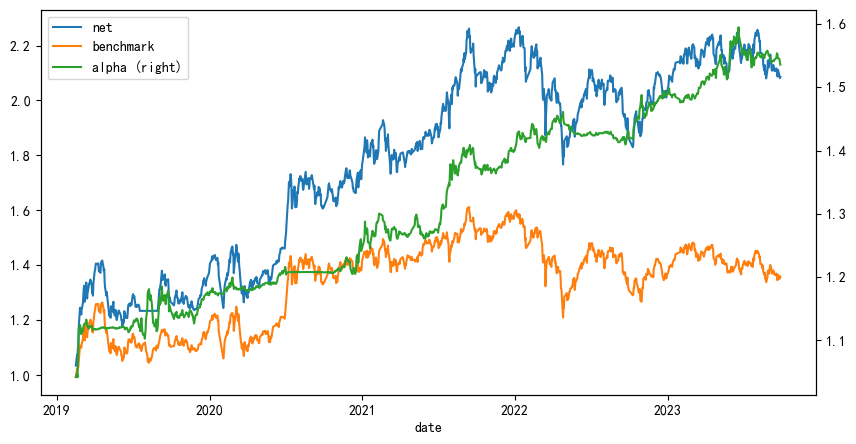

In [176]:
cumnet.plot(figsize = (10,5),secondary_y = 'alpha')
performance_record_level.T.iloc[:1]